In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

import numpy as np
import random

%matplotlib notebook
import matplotlib.pyplot as plt

from itertools import chain
from model import Discriminator1, Discriminator2, Encoder, Generator, Hencoder, Aggregator


#debug use
import pdb

In [2]:
def splitImage(x, divisor=2):
    w = x.shape[2]
    w = w // divisor
    
    res = []
    for i in range(divisor):
        for j in range(divisor):
            res.append(x[:, :, i*w:(i+1)*w, j*w:(j+1)*w])
        
    return torch.stack(res, -1)

In [3]:
trans = transforms.Compose([transforms.ToTensor(),
                            transforms.Normalize((0.5,), (0.5,))
                           ])

In [4]:
train_set = torchvision.datasets.MNIST(root="../mnist/", train=True, transform=trans, download=True)
test_set = torchvision.datasets.MNIST(root="../mnist/", train=False, transform=trans, download=True)

batch_size = 1024

train_loader = torch.utils.data.DataLoader(
                 dataset=train_set,
                 batch_size=batch_size,
                 shuffle=True)

test_loader = torch.utils.data.DataLoader(
                dataset=test_set,
                batch_size=batch_size,
                shuffle=False)

In [5]:
device = torch.device("cuda:0")

In [6]:
params = {
        "slope": 2e-2,
        "dropout": 0.2,
        "num_channels": 1,
        "z_dim": 128,
        "device": device,
        "num_views": 4,
        "aggregation_dim": 1024
}

In [7]:
D1 = Discriminator1(params)
D2 = Discriminator2(params)
G = Generator(params)
E = Encoder(params)
A = Aggregator(params)
H = Hencoder(params)

In [145]:
model_parameters = torch.load("saves/model.pth")

In [146]:
D1.load_state_dict(model_parameters["D1"])
D2.load_state_dict(model_parameters["D2"])
G.load_state_dict(model_parameters["G"])
E.load_state_dict(model_parameters["E"])
A.load_state_dict(model_parameters["A"])
H.load_state_dict(model_parameters["H"])

In [8]:
GEH = [G, E, H, A]
D1D2 = [D1, D2, A]

In [9]:
# optimizers
min_optimzer = optim.Adam(chain.from_iterable([m.parameters() for m in GEH]), 1e-4, betas=(0.5, 0.999), weight_decay=2.5*1e-5)
max_optimzer = optim.Adam(chain.from_iterable([m.parameters() for m in D1D2]), 1e-4, betas=(0.5, 0.999), weight_decay=2.5*1e-5)

In [10]:
# set iteration to 0
iter_cnt = 0
EPS = 1e-12

In [100]:
[m.train() for m in GEH]
[m.to(device) for m in GEH]
[m.train() for m in D1D2]
[m.to(device) for m in D1D2]

for epoch in range(30):
        for batch_idx, (batch_x, _) in enumerate(train_loader):
            
            batch_x = batch_x.to(device)
            
            # real loss
            e = E(batch_x)
            D1_Y_out = D1(batch_x, e).squeeze()
            
            # fake loss with noise
            z = torch.randn(batch_x.shape[0], 128, 1, 1).to(device)
            Gz = G(z)
            D1_z_out = D1(Gz, z).squeeze()
            
            multiview = splitImage(batch_x).squeeze()
            # randomly select indices
            indices = random.sample(set([0, 1, 2, 3]), random.randint(1, 3))
            
            
            H_aggre = A(multiview, indices)
            Y_aggre = A(multiview, random.sample(set([0, 1, 2, 3]), random.randint(3, 4)))
            
            D2_r_out = D2(e.squeeze(), Y_aggre)
            
            H_X = H(H_aggre)
            H_X_PRIME = H(Y_aggre)
            
            D2_f_out = D2(H_X.sample(), H_aggre)
            
            kl_loss = torch.distributions.kl.kl_divergence(H_X, H_X_PRIME).sum()
            
            # loss calculation
            max_loss = -torch.mean(torch.log(D1_Y_out + EPS) + torch.log(1 - D1_z_out + EPS)) \
                         -torch.mean(torch.log(D2_r_out + EPS) + torch.log(1 - D2_f_out + EPS))
            
            min_loss = -torch.mean(torch.log(D1_z_out + EPS) + torch.log(1 - D1_Y_out + EPS)) \
                        -torch.mean(torch.log(D2_f_out + EPS) + torch.log(1 - D2_r_out + EPS)) + kl_loss
            
#             max_loss = -torch.mean(torch.log(D2_r_out + EPS) + torch.log(1 - D2_f_out + EPS))       
#             min_loss = -torch.mean(torch.log(D2_f_out + EPS) + torch.log(1 - D2_r_out + EPS)) + kl_loss
            
            max_optimzer.zero_grad()
            max_loss.backward(retain_graph=True)
            max_optimzer.step()
            
            min_optimzer.zero_grad()
            min_loss.backward()
            min_optimzer.step()
            
            if iter_cnt % 100 == 0:
                print("Iter ", iter_cnt, " Max_Loss ", max_loss.item(), " Min_Loss ", min_loss.item(), " KL Loss ",
                     kl_loss.item())
            
            iter_cnt += 1
            
            

Iter  11000  Max_Loss  3.243974447250366  Min_Loss  2.1978771686553955  KL Loss  0.00033437757520005107
Iter  11100  Max_Loss  1.429561972618103  Min_Loss  2.2487878799438477  KL Loss  0.00027526653138920665
Iter  11200  Max_Loss  3.083364963531494  Min_Loss  0.6912367343902588  KL Loss  0.0007345514022745192
Iter  11300  Max_Loss  2.4783589839935303  Min_Loss  1.0996534824371338  KL Loss  0.007145682815462351
Iter  11400  Max_Loss  0.43943706154823303  Min_Loss  5.011327743530273  KL Loss  0.0035474239848554134
Iter  11500  Max_Loss  0.8026511073112488  Min_Loss  2.3737659454345703  KL Loss  0.006437362637370825
Iter  11600  Max_Loss  1.323986291885376  Min_Loss  1.699021816253662  KL Loss  0.0010849115205928683
Iter  11700  Max_Loss  0.9535243511199951  Min_Loss  2.053060293197632  KL Loss  0.009097229689359665
Iter  11800  Max_Loss  1.8295005559921265  Min_Loss  1.6438143253326416  KL Loss  0.0017292979173362255
Iter  11900  Max_Loss  2.5840983390808105  Min_Loss  5.723815441131592 

In [83]:
torch.save({'D1': D1.state_dict(),
            'D2': D2.state_dict(),
            'G': G.state_dict(),
            'E': E.state_dict(),
            'A': A.state_dict(),
            'H': H.state_dict()
           }, "./saves/model.pth")

<IPython.core.display.Javascript object>


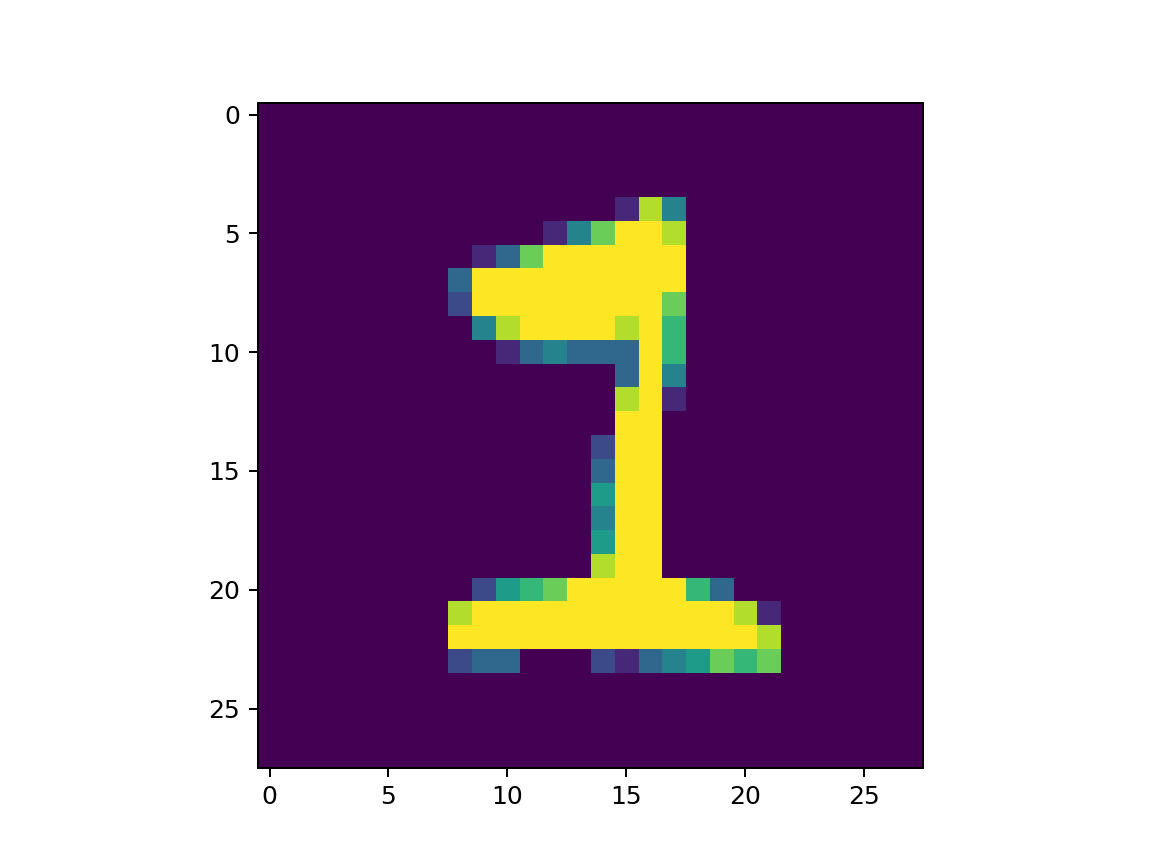

In [148]:
G.eval()
E.eval()
H.eval()
A.eval()

real = batch_x[14].detach().unsqueeze(0)
plt.imshow(real.cpu().squeeze().numpy())

<IPython.core.display.Javascript object>


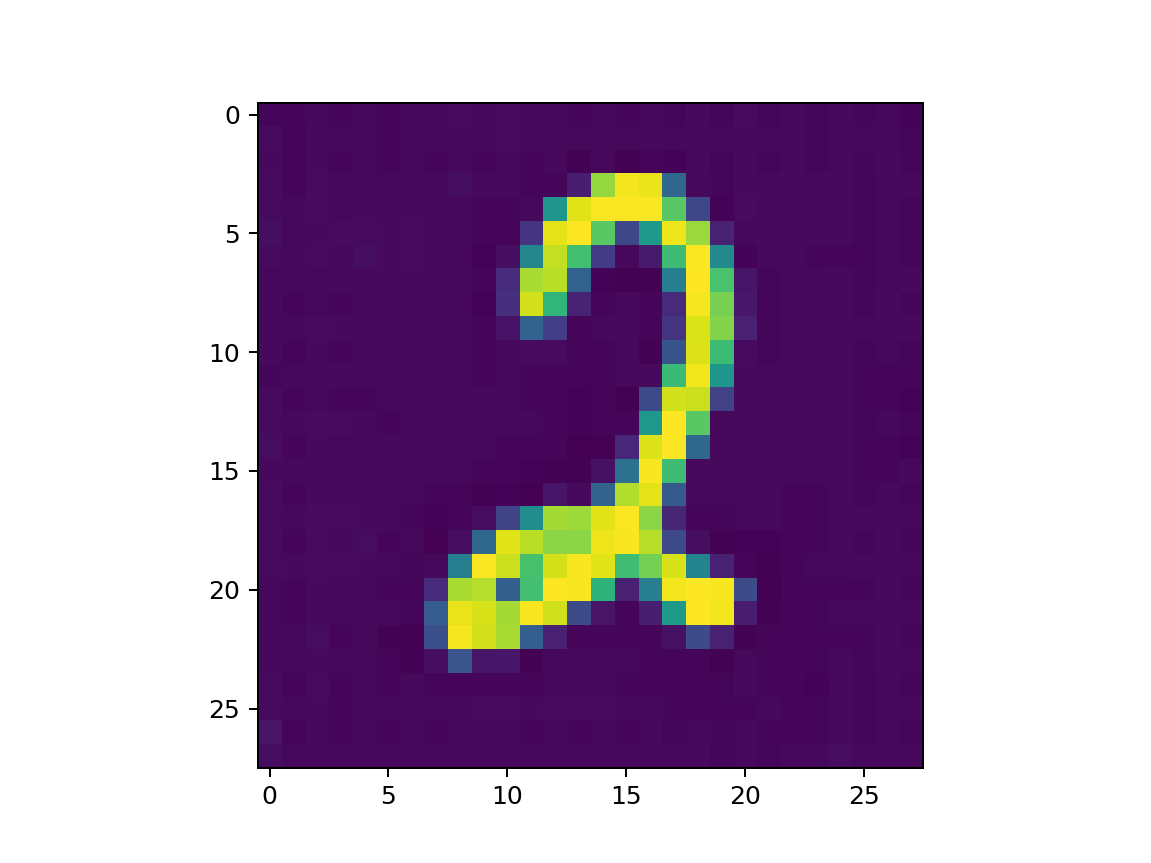

In [149]:
z = E(real)
image = G(z)
plt.imshow(image.detach().cpu().squeeze().numpy())

<IPython.core.display.Javascript object>


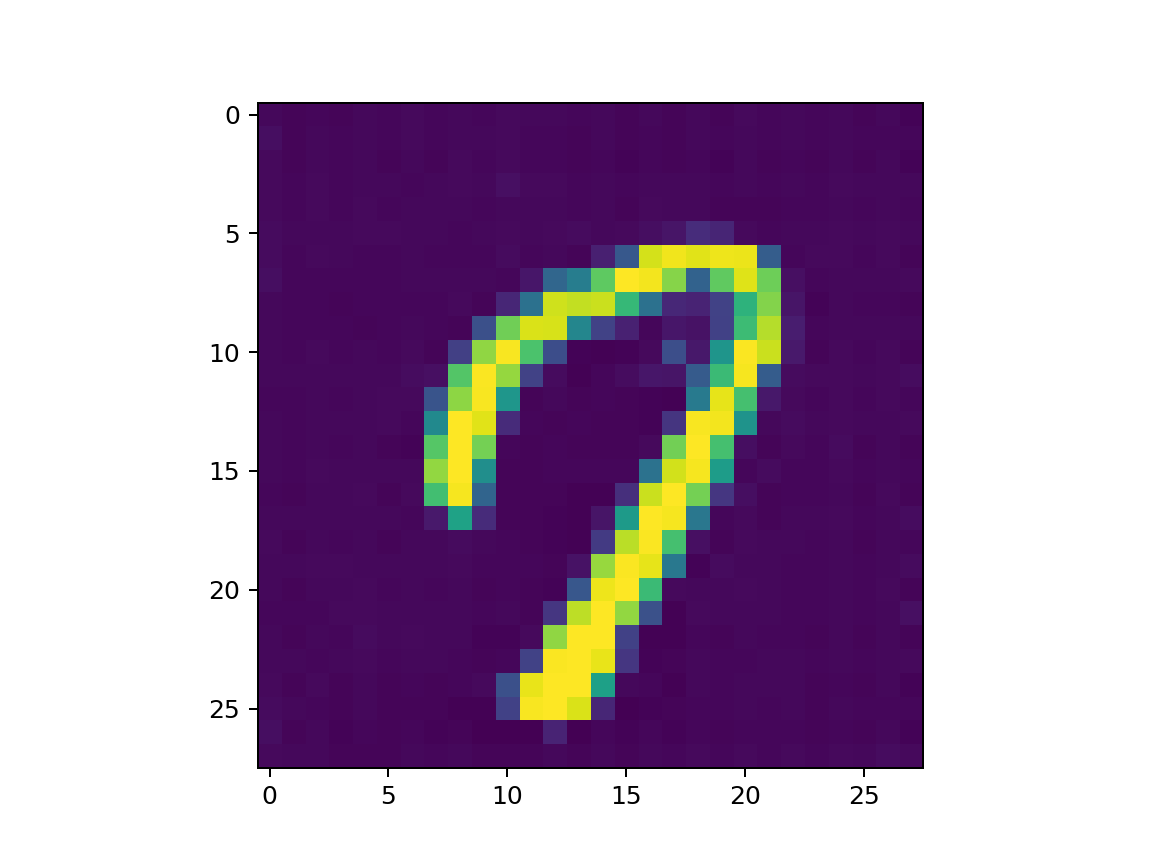

In [150]:
multiview = splitImage(real).squeeze().unsqueeze(0)
Y_aggre = A(multiview, [0, 1])
z = H(Y_aggre).sample().unsqueeze(-1).unsqueeze(-1)
image = G(z)
plt.imshow(image.detach().cpu().squeeze().numpy())